# Stock Market Prediction and Forecasting using Stacked LSTM

In [1]:
#Data Collection
import pandas_datareader as pdr

In [3]:
key = '2ce5238ab7782b4150af996957b5b1f2f88153fb'
df = pdr.get_data_tiingo('AAPL', api_key=key)

C:\Users\Nilesh Aggarwal\anaconda3\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('AAPL.csv')

In [9]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,AAPL,2022-06-22 00:00:00+00:00,135.35,137.760,133.910,134.790,73409234,135.35,137.760,133.910,134.790,73409234,0.0,1.0
1254,AAPL,2022-06-23 00:00:00+00:00,138.27,138.590,135.630,136.820,72433768,138.27,138.590,135.630,136.820,72433768,0.0,1.0
1255,AAPL,2022-06-24 00:00:00+00:00,141.66,141.910,139.770,139.900,89116837,141.66,141.910,139.770,139.900,89116837,0.0,1.0
1256,AAPL,2022-06-27 00:00:00+00:00,141.66,143.490,140.965,142.695,70207908,141.66,143.490,140.965,142.695,70207908,0.0,1.0
1257,AAPL,2022-06-28 00:00:00+00:00,137.44,143.422,137.325,142.130,67315328,137.44,143.422,137.325,142.130,67315328,0.0,1.0


In [11]:
# Picking up 'close' column
df1 = df.reset_index()['close']

In [12]:
df1

0       143.68
1       144.02
2       143.50
3       144.09
4       142.73
         ...  
1253    135.35
1254    138.27
1255    141.66
1256    141.66
1257    137.44
Name: close, Length: 1258, dtype: float64

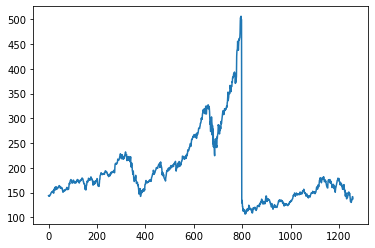

In [13]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [15]:
# LSTM are sensitive to the scale of data, so we apply MinMax scaler

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
# df1 got transformed between 0-1, with a scaler factor, which is individual for every stock
df1

array([[0.09227301],
       [0.09312461],
       [0.09182217],
       ...,
       [0.08721353],
       [0.08721353],
       [0.07664371]])

In [17]:
# Splitting dataset into train and test
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :1]

In [19]:
len(train_data), len(test_data)

(817, 441)

In [20]:
import numpy
# Converting an array of closing values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return numpy.array(dataX), numpy.array(dataY)

In [21]:
# Reshape into x=t, t+1, t+2, t+3 and Y = t+4, the the value of time_step is 3
time_step = 100
X_train, y_train= create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [24]:
print(X_train.shape), print(y_train.shape)
# x_trian --> 100 features, y_train --> 1
# total features --> 716

(716, 100)
(716,)


(None, None)

In [25]:
# Reshaping the input of X_train to a 3 Dimensional dataframe which is requirement for LSTM model
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test= X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [26]:
print(X_train.shape), print(X_test.shape)

(716, 100, 1)
(340, 100, 1)


(None, None)

In [28]:
# Creating Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [29]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1))) #100,1 is the shape of x_train
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Fitting the data
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 12s 372ms/step - loss: 0.0348 - val_loss: 0.0012
Epoch 2/100
12/12 [==============================] - 2s 206ms/step - loss: 0.0166 - val_loss: 0.0094
Epoch 3/100
12/12 [==============================] - 2s 210ms/step - loss: 0.0121 - val_loss: 0.0012
Epoch 4/100
12/12 [==============================] - 2s 208ms/step - loss: 0.0098 - val_loss: 0.0025
Epoch 5/100
12/12 [==============================] - 2s 202ms/step - loss: 0.0089 - val_loss: 5.1829e-04
Epoch 6/100
12/12 [==============================] - 2s 200ms/step - loss: 0.0083 - val_loss: 3.0249e-04
Epoch 7/100
12/12 [==============================] - 3s 234ms/step - loss: 0.0074 - val_loss: 5.3227e-04
Epoch 8/100
12/12 [==============================] - 3s 216ms/step - loss: 0.0074 - val_loss: 6.3041e-04
Epoch 9/100
12/12 [==============================] - 3s 226ms/step - loss: 0.0079 - val_loss: 2.3525e-04
Epoch 10/100
12/12 [==============================] - 2s 203ms/step - 

12/12 [==============================] - 2s 178ms/step - loss: 0.0046 - val_loss: 4.5078e-04
Epoch 79/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 80/100
12/12 [==============================] - 2s 179ms/step - loss: 0.0040 - val_loss: 4.0353e-04
Epoch 81/100
12/12 [==============================] - 2s 179ms/step - loss: 0.0027 - val_loss: 4.2705e-04
Epoch 82/100
12/12 [==============================] - 2s 178ms/step - loss: 0.0021 - val_loss: 2.3627e-04
Epoch 83/100
12/12 [==============================] - 2s 179ms/step - loss: 0.0018 - val_loss: 2.9477e-04
Epoch 84/100
12/12 [==============================] - 2s 183ms/step - loss: 0.0017 - val_loss: 2.3396e-04
Epoch 85/100
12/12 [==============================] - 2s 177ms/step - loss: 0.0014 - val_loss: 1.8150e-04
Epoch 86/100
12/12 [==============================] - 2s 176ms/step - loss: 0.0014 - val_loss: 2.1623e-04
Epoch 87/100
12/12 [==============================] - 2s 179ms/

In [33]:
import tensorflow as tf

In [34]:
tf.__version__

'2.9.1'

In [35]:
# Doing the prediction and checking performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 39ms/step


In [36]:
#Transforming back to the original values from the MinMax scaler
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [42]:
# Calculating RMSE Performance Metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

246.1779187307414

In [43]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

170.55629685121866

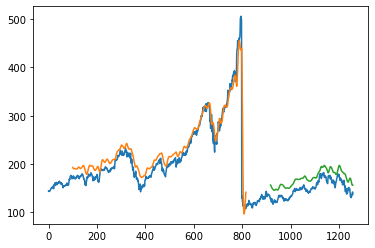

In [44]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [47]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [48]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [49]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.12752202]
101
1 day input [0.16418284 0.16235441 0.1702943  0.17392611 0.16350657 0.15479023
 0.15539136 0.16518472 0.16458359 0.15539136 0.15143394 0.14396994
 0.13332498 0.14001252 0.14529743 0.1459737  0.14116468 0.14958046
 0.14875391 0.14108954 0.13139637 0.12673763 0.14053851 0.12944271
 0.11994991 0.1096556  0.1208516  0.13212273 0.13470257 0.14311835
 0.14662492 0.15524108 0.1587226  0.16839073 0.17001879 0.17222292
 0.1806387  0.17765811 0.16974327 0.16899186 0.17933626 0.17087038
 0.16278021 0.16355667 0.15842204 0.14755166 0.15233563 0.1591985
 0.1463995  0.14584847 0.15168441 0.15125861 0.14922981 0.13763306
 0.14036318 0.12513463 0.12455855 0.14226675 0.12726362 0.12804008
 0.13184721 0.14822793 0.12505949 0.12633688 0.11326237 0.11939887
 0.09933626 0.08946775 0.10086412 0.09693175 0.10619912 0.08510958
 0.07641828 0.07701941 0.09084534 0.08395742 0.08435817 0.09252348
 0.107201   0.10519724 0.10487163 0.11113338 0.096531   0.09843456
 0.10487163 0.10299311 0.08966813 

11 day output [[0.24392778]]
12 day input [0.14396994 0.13332498 0.14001252 0.14529743 0.1459737  0.14116468
 0.14958046 0.14875391 0.14108954 0.13139637 0.12673763 0.14053851
 0.12944271 0.11994991 0.1096556  0.1208516  0.13212273 0.13470257
 0.14311835 0.14662492 0.15524108 0.1587226  0.16839073 0.17001879
 0.17222292 0.1806387  0.17765811 0.16974327 0.16899186 0.17933626
 0.17087038 0.16278021 0.16355667 0.15842204 0.14755166 0.15233563
 0.1591985  0.1463995  0.14584847 0.15168441 0.15125861 0.14922981
 0.13763306 0.14036318 0.12513463 0.12455855 0.14226675 0.12726362
 0.12804008 0.13184721 0.14822793 0.12505949 0.12633688 0.11326237
 0.11939887 0.09933626 0.08946775 0.10086412 0.09693175 0.10619912
 0.08510958 0.07641828 0.07701941 0.09084534 0.08395742 0.08435817
 0.09252348 0.107201   0.10519724 0.10487163 0.11113338 0.096531
 0.09843456 0.10487163 0.10299311 0.08966813 0.07586725 0.0627176
 0.06492173 0.07160927 0.05815905 0.06191609 0.07271133 0.07140889
 0.0787226  0.08721353 

22 day input [0.12673763 0.14053851 0.12944271 0.11994991 0.1096556  0.1208516
 0.13212273 0.13470257 0.14311835 0.14662492 0.15524108 0.1587226
 0.16839073 0.17001879 0.17222292 0.1806387  0.17765811 0.16974327
 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667 0.15842204
 0.14755166 0.15233563 0.1591985  0.1463995  0.14584847 0.15168441
 0.15125861 0.14922981 0.13763306 0.14036318 0.12513463 0.12455855
 0.14226675 0.12726362 0.12804008 0.13184721 0.14822793 0.12505949
 0.12633688 0.11326237 0.11939887 0.09933626 0.08946775 0.10086412
 0.09693175 0.10619912 0.08510958 0.07641828 0.07701941 0.09084534
 0.08395742 0.08435817 0.09252348 0.107201   0.10519724 0.10487163
 0.11113338 0.096531   0.09843456 0.10487163 0.10299311 0.08966813
 0.07586725 0.0627176  0.06492173 0.07160927 0.05815905 0.06191609
 0.07271133 0.07140889 0.0787226  0.08721353 0.08721353 0.07664371
 0.12752202 0.13247336 0.13985237 0.14916879 0.159841   0.17137343
 0.18339406 0.19563937 0.20792598 0.2201259  0.2321

 0.37570256 0.38317096 0.3904652  0.39759395]
29 day output [[0.40456343]]
[[0.12752202153205872], [0.13247336447238922], [0.139852374792099], [0.14916878938674927], [0.15984100103378296], [0.1713734269142151], [0.18339405953884125], [0.19563937187194824], [0.2079259753227234], [0.22012589871883392], [0.2321481704711914], [0.24392777681350708], [0.2554182708263397], [0.2665880620479584], [0.2774176597595215], [0.2878977060317993], [0.2980274558067322], [0.307813435792923], [0.3172675371170044], [0.32640573382377625], [0.3352470099925995], [0.3438115417957306], [0.3521200716495514], [0.3601926267147064], [0.3680477738380432], [0.37570255994796753], [0.3831709623336792], [0.3904651999473572], [0.3975939452648163], [0.40456342697143555]]


In [50]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [51]:
import matplotlib.pyplot as plt

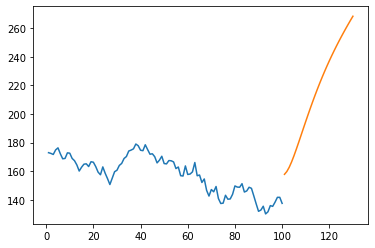

In [52]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

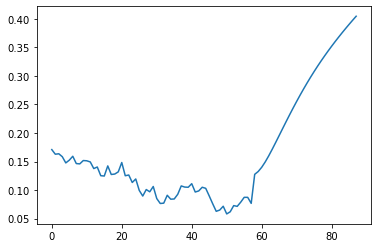

In [53]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [54]:
df3=scaler.inverse_transform(df3).tolist()

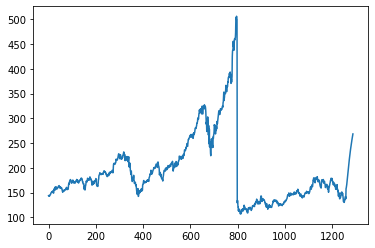

In [55]:
plt.plot(df3)